# NeuroDetect - A Brain Tumor Detection System
***
##### Author: Mayur Bhai
##### Contact: mayurbhai2324@gmail.com
##### Date: Sunday, November 24th, 2024

## Table of Contents
***

1. [Introduction](#Introduction)
2. [Dataset](#Dataset)
    - [Data Preparation](#Data-Preparation-and-Preprocessing)
    - [Data Preprocessing](#Data-Preprocessing)
3. [Modeling](#Modeling)
    - [Logistic Regression](#Logistic-Regression)
    - [Support Vector Machines (SVM)](#Support-Vector-Machines-(SVM))
    - [Random Forest](#Random-Forest)
    - [Convolutional Neural Network](#Convolutional-Neural-Network)
4. [Conclusion](#Conclusion)
5. [Next Steps](#Next-Steps)

## Introduction
***
We will continue from our previous notebook, but this time we will focus more on creating various baseline models to see how image data can be classified using different models. The machine learning models that will be compared are Logistic Regression, Support Vector Machine (SVM), Random Forest, and, lastly, a Convolutional Neural Network.

To quickly refresh, the primary goal of this project is to build a machine learning model that can **accurately detect the presence of a tumour in an MRI image and identify the tumour type.** This model aims to enhance the efficiency and precision of brain tumour diagnosis, supporting radiologists, surgeons, and researchers by:
- Reduce diagnostic times
- Reduce time for treatment planning
- Increasing patient turnaround
- Minimizing costs linked to misdiagnoses and incorrect treatments

**Using machine learning, how can we identify tumours in MRI scans to improve early detection, prevent further complications, and accelerate treatment planning?**


## Dataset
***

As a reminder, we will be using a mix of image data from various data sources all bundled into one folder. The dataset is a combination of the three datasets: figshare, SARTAJ dataset and the Br35H dataset. The dataset was combined collected from __[Kaggle.](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)__ The dataset contains 7023 MRI images of brain tumours classified into glioma, meningioma, pituitary and non-tumor. Images are already sorted and arranged to train and test folders within the **Data** directory.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import glob
import cv2
import random
#---------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

#### Change Directory

First thing we'll do is to figure out where our current folder is located and change the directory so that it points to the folder with the image data. The os (Operating System) library will be used to determine that. We will set our base directory as the directory with the image data located.

**Google Colab was used for this notebook. You will need to mount Google Drive, ensuring the data file is inside a folder on your local Google Drive.**

In [3]:
# Check the current system directory
os.getcwd()

'/content'

In [4]:
# Change directory so that it points to the folder with the data
os.chdir("/content/drive/MyDrive/neurodetect_capstone/data")
os.getcwd()

'/content/drive/MyDrive/neurodetect_capstone/data'

In [5]:
# Set base directory to the data folder
base_dir = os.getcwd()


Define a function to prepare the dataset by taking a directory as input. This function will serve as the main tool to import image paths and labels from subfolders (without loading the actual images). By importing only paths and labels, we can efficiently examine and process the data without the overhead of loading all images. The image paths can later be used to load images as needed. The function returns lists of data paths and corresponding labels.

In [6]:
def prepare_dataset(directory):
    '''
    This function takes in the path of the data directory, go through all image path, subfolders and combine it into
    2 arrays. Each element in array is the path to the image and the image label.

    Args:
        directory (str): Directory path for the data directory

    Returns:
        data_path (array): Return array of each image data path
        data_labels (array): Return array of each image labels

    Examples:
        >>> path, label = prepare_dataset(directory)
        >>> path
        [data/train/dog_image_1.jpg, data/train/cat_image_1.jpg]
        >>> label
        [dog, cat]
    '''

    # Lists to store data path and labels
    data_path = []
    data_labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)

    return data_path, data_labels

#### Data Preparation
Next, we'll begin loading and examining our data. First, we’ll set up the directory paths for both the training and test images. The dataset is structured so that images are already separated into their respective folders by class. We’ll load each image path and its label into a data frame and import all the images based on the image path.

In [7]:
# Train and test directories
train_dir = base_dir + r'/Training/'
test_dir = base_dir + r'/Testing/'

# Getting data using above function
train_paths, train_labels = prepare_dataset(train_dir)
test_paths, test_labels = prepare_dataset(test_dir)

# Turn them into pandas DF
train_df = pd.DataFrame({'Class Path':train_paths, 'Class':train_labels})
test_df = pd.DataFrame({'Class Path':test_paths, 'Class':test_labels})

In [8]:
# Shape of data frame and sanity check
print(train_df.shape)
print(test_df.shape)

(5712, 2)
(1311, 2)


In [9]:
# Print train head
train_df.head()

,Class Path,Class
0,/content/drive/MyDrive/neurodetect_capstone/da...,pituitary
1,/content/drive/MyDrive/neurodetect_capstone/da...,pituitary
2,/content/drive/MyDrive/neurodetect_capstone/da...,pituitary
3,/content/drive/MyDrive/neurodetect_capstone/da...,pituitary
4,/content/drive/MyDrive/neurodetect_capstone/da...,pituitary


In [10]:
# Print test head
test_df.head()

,Class Path,Class
0,/content/drive/MyDrive/neurodetect_capstone/da...,pituitary
1,/content/drive/MyDrive/neurodetect_capstone/da...,pituitary
2,/content/drive/MyDrive/neurodetect_capstone/da...,pituitary
3,/content/drive/MyDrive/neurodetect_capstone/da...,pituitary
4,/content/drive/MyDrive/neurodetect_capstone/da...,pituitary


#### Data Preprocessing
Next, we'll begin loading our images and labels based on the image paths in the dataframe. While loading, we will convert the images to grayscale and resize them to (64, 64) to ensure all image sizes are consistent. Once the images are loaded and split into training and testing sets, we will begin preprocessing them. The training and testing images (X_train and X_test) will be flattened for our non-deep learning models, and the training and testing labels (Y_train and Y_test) will be encoded to convert them from categorical string values to numerical values so that our model can understand them.

The function below takes in the dataframe containing the image paths and the desired image size for resizing. It resizes the images, converts them to grayscale, and outputs an array of images and labels.

In [11]:
def load_images_and_labels(df, img_size=(64, 64)):
    """
    Load images and their corresponding labels from the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and class labels.
        img_size (tuple): Target size for resizing images (height, width).

    Returns:
        X (numpy.ndarray): Array of image data.
        y (numpy.ndarray): Array of labels encoded as integers.
    """
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = row['Class Path']
        label = row['Class']

        # Load the image from image path
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Image not found at {img_path}. Skipping.")
            continue

        # Resize the image
        img = cv2.resize(img, img_size)

        # Append to lists
        images.append(img)
        labels.append(label)

    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    return X, y

In [12]:
# Load training data
img_size = (64, 64)  # Set target image size
X_train, y_train = load_images_and_labels(train_df, img_size)
X_test, y_test = load_images_and_labels(test_df, img_size)

In [13]:
# Reshape the image arrays to flatten it for non-nn models
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Flatten images
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [14]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [15]:
# Sanity check
print("Shape of Flatten X_train:", X_train_flattened.shape)
print("Shape of Encoded y_train:", y_train_encoded.shape)
print("Shape of Flatten X_test:", X_test_flattened.shape)
print("Shape of Encoded y_test:", y_test_encoded.shape)

Shape of Flatten X_train: (5712, 4096)
Shape of Encoded y_train: (5712,)
Shape of Flatten X_test: (1311, 4096)
Shape of Encoded y_test: (1311,)


## Modelling
***

Now that our data has been imported and preprocessed, we can begin modeling. Image data classification is typically performed using deep learning models such as Convolutional Neural Networks (CNNs). However, for the purpose of this notebook, we will train various non-deep learning models to evaluate their performance compared to a deep learning model like a CNN. By analyzing the results of different models, we can select the best one to move forward with and fine-tune further. The four main machine learning models we will focus on are Logistic Regression, Support Vector Machines (SVM), Random Forest, and, finally, a Convolutional Neural Network (CNN).

#### Logisitc Regression

The first model we will train with our image data is a typical Logistic Regression model. For image data classification, we will use the saga solver.

In [16]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(solver='saga', penalty='l1', C=10, max_iter=20)

# Train the model on the training data
logistic_model.fit(X_train_flattened, y_train_encoded)

LogisticRegression(C=10, max_iter=20, penalty='l1', solver='saga')

In [17]:
# Training and testing accuracy
print("Train Accuracy:",logistic_model.score(X_train_flattened, y_train_encoded))
print("Test Accuracy:",logistic_model.score(X_test_flattened, y_test_encoded))

Train Accuracy: 0.8974089635854342
Test Accuracy: 0.8146453089244852


In [18]:
# Model Classes
print(logistic_model.classes_)
print(label_encoder.classes_)

[0 1 2 3]
['glioma' 'meningioma' 'notumor' 'pituitary']


In [19]:
# Predict on the test set
y_pred_logreg = logistic_model.predict(X_test_flattened)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test_encoded, y_pred_logreg)
print("Accuracy of Logistic Regression Model:", accuracy_logreg)

Accuracy of Logistic Regression Model: 0.8146453089244852


In [20]:
# Print classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test_encoded, y_pred_logreg, target_names=label_encoder.classes_))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

      glioma       0.77      0.71      0.73       300
  meningioma       0.68      0.61      0.64       306
     notumor       0.89      0.95      0.92       405
   pituitary       0.87      0.95      0.91       300

    accuracy                           0.81      1311
   macro avg       0.80      0.80      0.80      1311
weighted avg       0.81      0.81      0.81      1311



The Logistic Regression model achieved a training accuracy of 89.74% and a test accuracy of 81.46%, showing a drop in performance on the test set, which suggests potential overfitting. The model performs well in detecting "no tumor" (95% recall) and "pituitary" (95% recall), but struggles with "glioma" and "meningioma," exhibiting lower recall (71% and 61%, respectively). The macro average F1-score is 0.80, indicating that the model performs reasonably well overall, but its performance is imbalanced, with poorer classification in certain classes. This is expected from a basic Logistic Regression model without hyperparameter tuning.

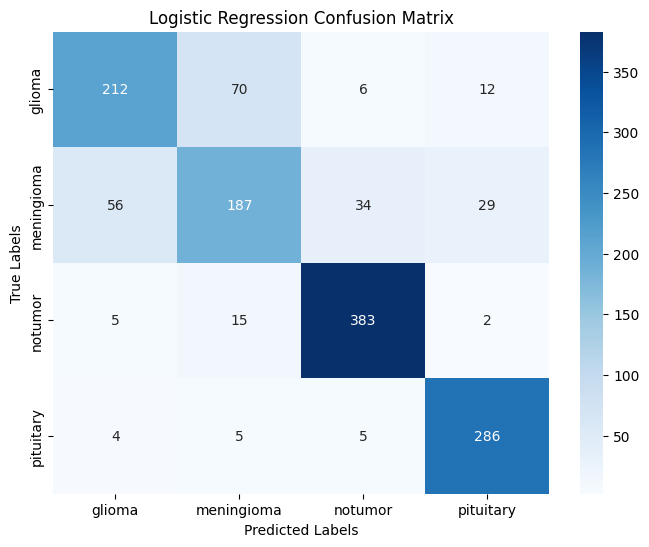

In [21]:
# Print confusion matrix
con_matrix_logreg = confusion_matrix(y_test_encoded, y_pred_logreg)
class_names = label_encoder.classes_

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(con_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Based on the confusion matrix, we notice that overall our model is performing mediocrely. The model has difficulty classifying images in the meningioma and glioma classes, as evidenced by our classification report. The model predicted 56 meningioma images as glioma, 34 as "no tumor," and 29 as pituitary. It also misclassified 70 glioma images as meningioma. Creating a pipeline for further hyperparameter tuning might improve this model, but as a baseline, it is still a solid model.

Let's examine the coefficients as an image to better understand what the model is looking at and interpreting.

In [22]:
# Shape of coefficients matrix
logistic_model.coef_.shape

(4, 4096)

In [23]:
# Currently 4 x 4096, we need this to be 4 x 64 x 64
coefs = logistic_model.coef_.reshape(4, 64, 64)
coefs.shape

(4, 64, 64)

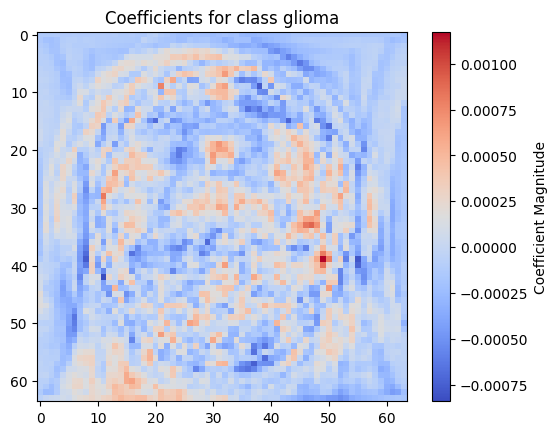

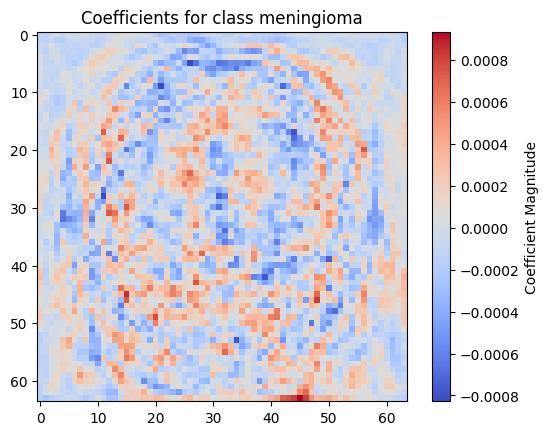

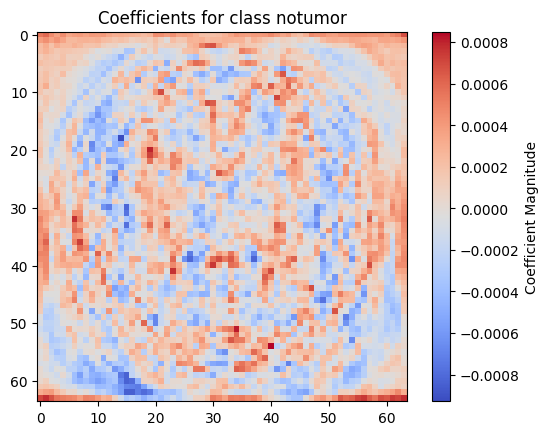

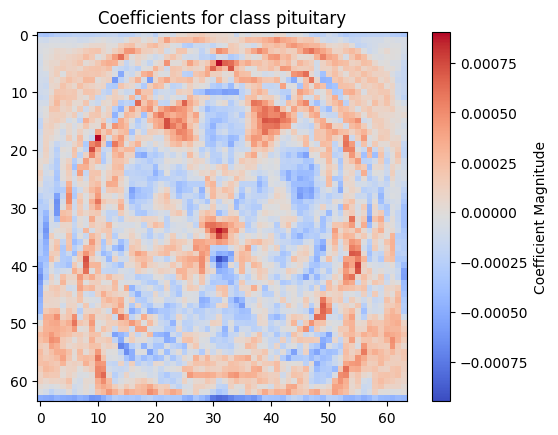

In [24]:
# Plot coefficents as an image for each class
for i in range(0,4):
    plt.imshow(coefs[i], cmap='coolwarm', interpolation='nearest')
    plt.title(f'Coefficients for class {class_names[i]}')
    plt.colorbar(label="Coefficient Magnitude")
    plt.show()

After plotting the coefficients learned by our model, we observe something interesting. The coefficients represent the importance of each feature (pixel value) in predicting a class. For the "no tumor" class, we see positive coefficient magnitudes concentrated mostly on the outer edges of the images, while for "pituitary," the concentration is in the middle and higher up. For "glioma" and "meningioma," there isn't as much positive coefficient magnitude compared to the other two classes, suggesting that the model has a harder time classifying these two classes. This observation aligns with our analysis of the confusion matrix.

#### Support Vector Machines (SVM)

The second model we will train with our image data is a Support Vector Machine (SVM) model. SVM is a popular machine learning model that was widely used for image classification before the introduction of neural networks. Before training this model, we will perform Principal Component Analysis (PCA) on X_train and X_test to reduce their dimensionality. This step will help improve the model's performance.

In [25]:
# Reduce dimensionality with PCA
pca = PCA(n_components=100)  # Reduce to 100 principal components
X_train_pca = pca.fit_transform(X_train_flattened)
X_test_pca = pca.transform(X_test_flattened)

In [26]:
# Train an SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale')  # Use RBF kernel
svm_model.fit(X_train_pca, y_train_encoded)

SVC(C=1)

In [27]:
# Training and testing accuracy
print("Train Accuracy:",svm_model.score(X_train_pca, y_train_encoded))
print("Test Accuracy:",svm_model.score(X_test_pca, y_test_encoded))

Train Accuracy: 0.9248949579831933
Test Accuracy: 0.8832951945080092


In [28]:
# Predict on the test set
y_pred_svm = svm_model.predict(X_test_pca)

# Evaluate the model
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)
print("Accuracy of SVM Model:", accuracy_svm)

Accuracy of SVM Model: 0.8832951945080092


In [29]:
# Print classification report
print("\nSVM Classification Report:")
print(classification_report(y_test_encoded, y_pred_svm, target_names=label_encoder.classes_))


SVM Classification Report:
              precision    recall  f1-score   support

      glioma       0.87      0.82      0.84       300
  meningioma       0.81      0.75      0.78       306
     notumor       0.94      0.97      0.95       405
   pituitary       0.90      0.97      0.93       300

    accuracy                           0.88      1311
   macro avg       0.88      0.88      0.88      1311
weighted avg       0.88      0.88      0.88      1311



The SVM model performed much better than the Logistic Regression model. It achieved a training accuracy of 92.49% and a test accuracy of 88.33%, indicating that it performs well but still overfits the training data. Similar to the Logistic Regression model, the SVM model performs best on the "no tumor" and "pituitary" classes, both achieving a recall score of 97%. The SVM model faces the same issue of lower performance on "glioma" (82% recall) and "meningioma" (75% recall). Performing PCA to reduce dimensionality definitely helped improve the model's performance, though further tuning could lead to additional improvements.

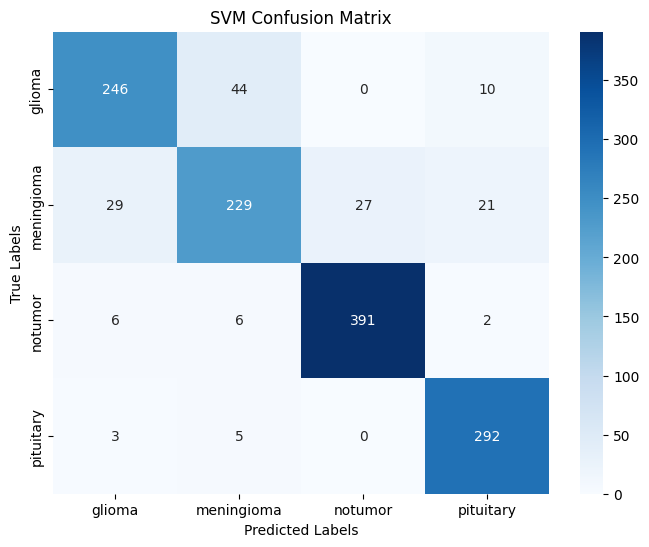

In [30]:
# Print confusion matrix
con_matrix_svm = confusion_matrix(y_test_encoded, y_pred_svm)
class_names = label_encoder.classes_

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(con_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("SVM Confusion Matrix")
plt.show()

The confusion matrix is similar but better than the Logistic Regression confusion matrix. The SVM model predicted 29 meningioma images as glioma, 27 as "no tumor," and 21 as pituitary. Once again, it misclassified 44 glioma images as meningioma, which is high, just like the Logistic Regression model.

#### Random Forest

The third model we will train with our image data is a Random Forest model. A Random Forest model consists of multiple decision trees. The main objective of using this model is to demonstrate how a relatively simple model can perform without requiring extensive hyperparameter tuning, as is often needed for CNNs. Additionally, this model will serve as a good baseline for comparison with more complex models.

In [31]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=5)

# Train the model on the training data
rf_model.fit(X_train_flattened, y_train_encoded)

RandomForestClassifier(max_depth=5, n_estimators=500)

In [32]:
# Training and testing accuracy
print("Train Accuracy:",rf_model.score(X_train_flattened, y_train_encoded))
print("Test Accuracy:",rf_model.score(X_test_flattened, y_test_encoded))

Train Accuracy: 0.8396358543417367
Test Accuracy: 0.7597254004576659


In [33]:
# Predict on the test set
y_pred_rf= rf_model.predict(X_test_flattened)

# Evaluate the model
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
print("Accuracy of Random Forest Model:", accuracy_rf)

Accuracy of Random Forest Model: 0.7597254004576659


In [34]:
# Print classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf, target_names=label_encoder.classes_))


Random Forest Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.63      0.76       300
  meningioma       0.62      0.51      0.56       306
     notumor       0.80      0.93      0.86       405
   pituitary       0.71      0.92      0.80       300

    accuracy                           0.76      1311
   macro avg       0.77      0.75      0.74      1311
weighted avg       0.77      0.76      0.75      1311



The Random Forest model performed the worst compared to the other two. It achieved a training accuracy of 83.96% and a test accuracy of 75.97%, indicating significant overfitting to the training data. The model was able to recall the "no tumor" and "pituitary" classes at a decent rate, with recall scores of 93% and 92%, respectively. However, the model performed extremely poorly with glioma and meningioma, achieving recall scores of 63% for "glioma" and 51% for "meningioma." Almost 50% of meningioma images are being falsely classified, which is no better than predicting all images as meningioma. It seems the Random Forest model struggles with handling images, particularly complex ones.

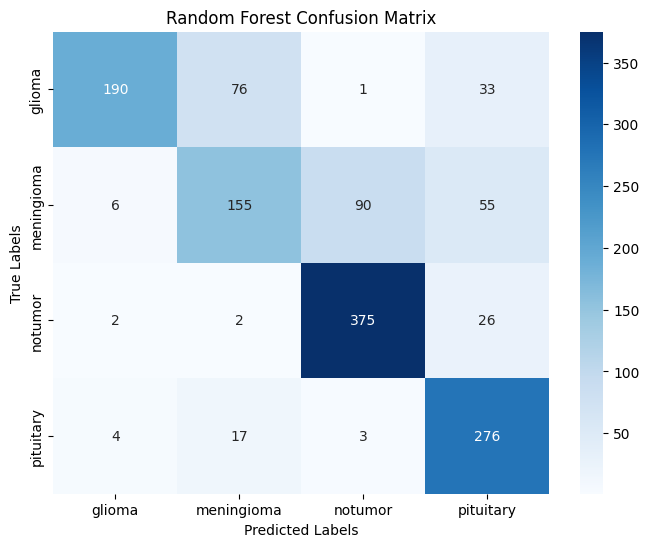

In [35]:
# Print confusion matrix
con_matrix_rf = confusion_matrix(y_test_encoded, y_pred_rf)
class_names = label_encoder.classes_

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(con_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Random Forest Confusion Matrix")
plt.show()

Our last non-deep learning model's confusion matrix shows a very interesting result. The SVM and Logistic Regression models have similar confusion matrices, where both misclassified meningioma and glioma. However, the Random Forest model falsely classified images as pituitary much more frequently than any of the other models we’ve seen. The model falsely classified 33 glioma, 55 meningioma, and 26 "no tumor" images as pituitary. It also misclassified 90 meningioma images as "no tumor" and 76 glioma images as meningioma. Overall, our Random Forest model performed significantly worse compared to Logistic Regression and SVM.

#### Convolutional Neural Network

Our final model will be a Convolutional Neural Network (CNN). CNNs are deep learning models that are widely regarded as the go-to solution for computer vision problems. For this model, we will keep the architecture very simple and baseline to allow for a fair comparison with the other models. As such, we will avoid adding too many layers, epochs or using dropout nodes to prevent overfitting.

We will begin by setting a random seed to ensure reproducibility.

In [36]:
def set_random_seed(seed):

    '''Random seeds for reproducability'''

    random.seed(seed)
    tf.random.set_seed(seed)

In [37]:
set_random_seed(123)

Neural Network models require separate validation, training, and test sets. While we could split our training set 80/20 to create a validation set, this would reduce the size of our training data and could lead to the model performing better than expected due to an insufficiently representative validation set. To address this, we will split our test set in half and use one portion as the validation set.

In [38]:
# Split the test data into validation and test sets
X_val, X_test, y_val_encoded, y_test_encoded = train_test_split(X_test, y_test_encoded, test_size=0.5, random_state=42)

In [39]:
# Sanity Check
print("Shape of X_train:", X_train.shape)
print("Shape of Encoded y_train:", y_train_encoded.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Encoded y_test:", y_test_encoded.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Encoded y_val:", y_val_encoded.shape)

Shape of X_train: (5712, 64, 64)
Shape of Encoded y_train: (5712,)
Shape of X_test: (656, 64, 64)
Shape of Encoded y_test: (656,)
Shape of X_val: (655, 64, 64)
Shape of Encoded y_val: (655,)


Since our images are divided into multiple classes, we will one-hot encode the labels into binary values and use them in our model. For the loss function, we will use categorical_crossentropy.

In [40]:
# Convert labels to one-hot encoding for multi-class classification
num_classes = len(label_encoder.classes_)

y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)

We must normalize and preprocess our images further before using them in our model. All our X variables will be normalized so that their values fall between 0 and 1.

In [41]:
# Normalize the image data
if X_train.max() > 1.0:
  X_train = X_train.astype('float32') / 255.0
  X_test = X_test.astype('float32') / 255.0
  X_val = X_val.astype('float32') / 255.0
  print(f"Normalized X_train range: {X_train.min()}-{X_train.max()}")
else:
  print("No further normalization needed.")

Normalized X_train range: 0.0-1.0


Build a basic CNN model.

In [42]:
#Define the CNN model
CNN_model = Sequential()

CNN_model.add(Conv2D(16, kernel_size=(3, 3), activation = 'relu', input_shape = (64, 64, 1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of our convolutional layers
CNN_model.add(Flatten())

# Fully connected (Dense) Layer
CNN_model.add(Dense(num_classes, activation='softmax'))

# Print out a summary of the network
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15376)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          61,508 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,668 (240.89 KB)

 Trainable params: 61,668 (240.89 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
CNN_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [44]:
history = CNN_model.fit(X_train, y_train_onehot,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_val, y_val_onehot))

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.6079 - loss: 0.9235 - val_accuracy: 0.7863 - val_loss: 0.5804
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8416 - loss: 0.4759 - val_accuracy: 0.8290 - val_loss: 0.4658
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.8741 - loss: 0.3840 - val_accuracy: 0.8473 - val_loss: 0.4122
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8985 - loss: 0.3242 - val_accuracy: 0.8534 - val_loss: 0.3824
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9153 - loss: 0.2781 - val_accuracy: 0.8580 - val_loss: 0.3649
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9270 - loss: 0.2423 - val_accuracy: 0.8595 - val_loss: 0.3481
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9349 - loss: 0.2134 - val_accuracy: 0.8641 - val_loss: 0.3266
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9421 - loss: 0.1887 - 

In [45]:
# Evaluate the model's performance on the test data
score = CNN_model.evaluate(X_test, y_test_onehot, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8985 - loss: 0.2695
Test loss: 0.28599077463150024
Test accuracy: 0.8978658318519592


In [46]:
# Predict labels
y_pred_cnn = CNN_model.predict(X_test).argmax(axis=1)

# Classification Report
print("CNN Classification Report:")
print(classification_report(y_test_encoded, y_pred_cnn, target_names=label_encoder.classes_))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
CNN Classification Report:
              precision    recall  f1-score   support

      glioma       0.82      0.93      0.87       149
  meningioma       0.87      0.68      0.76       148
     notumor       0.92      0.99      0.95       208
   pituitary       0.99      0.95      0.97       151

    accuracy                           0.90       656
   macro avg       0.90      0.89      0.89       656
weighted avg       0.90      0.90      0.89       656



The CNN model achieves a test accuracy of 89.79%, with a test loss of 0.29, indicating strong performance. The model excels in predicting "pituitary" and "notumor" classes, with precision and recall values of 0.99 and 0.95, respectively. However, it struggles with "meningioma," where the recall is lower at 0.68, indicating more false negatives. The "glioma" class has a balanced performance with an F1-score of 0.87. Overall, the model performs well across most classes, with a slight imbalance favoring the detection of certain tumor types, particularly non-tumor and pituitary tumors.

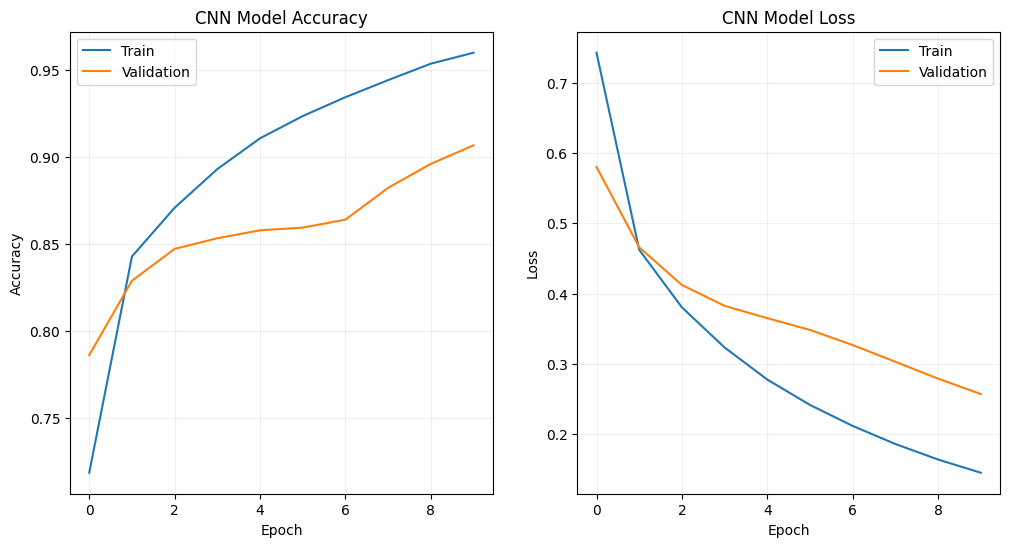

In [47]:
_, ax = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], )
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('CNN Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('CNN Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

Looking at our accuracy and loss graphs, we see an interesting trend. Despite only running the model for 10 epochs (as a reminder, we are running it for only 10 epochs to keep it a simple baseline model).

Training accuracy and validation accuracy are consistently increasing, which indicates that our model is learning effectively. An interesting observation is that the validation accuracy drastically jumps from epoch 6 to epoch 7. We also see a similar trend in the model's loss. The loss steadily decreases, suggesting the model is improving with each epoch.

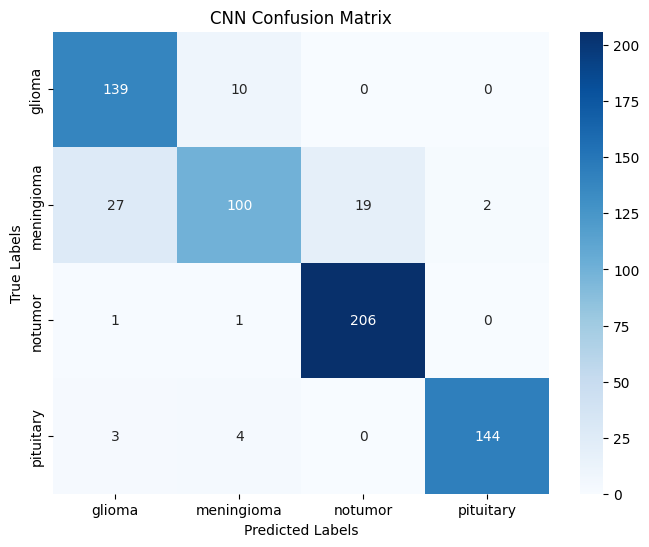

In [48]:
# Print confusion matrix
con_matrix_cnn = confusion_matrix(y_test_encoded, y_pred_cnn)
class_names = label_encoder.classes_

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(con_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("CNN Confusion Matrix")
plt.show()

Analyzing the confusion matrix, we notice that overall our model is performing well with minimal misclassification. However, it seems the model still has difficulty classifying images in the meningioma class. It predicted 27 meningioma images as glioma and 19 as "no tumor." This will require further analysis and tuning to reduce these misclassifications, but we will address this in the next phase.

Let’s look at some examples of the misclassified images. To do this, we will display all the incorrect photos along with their correct labels.

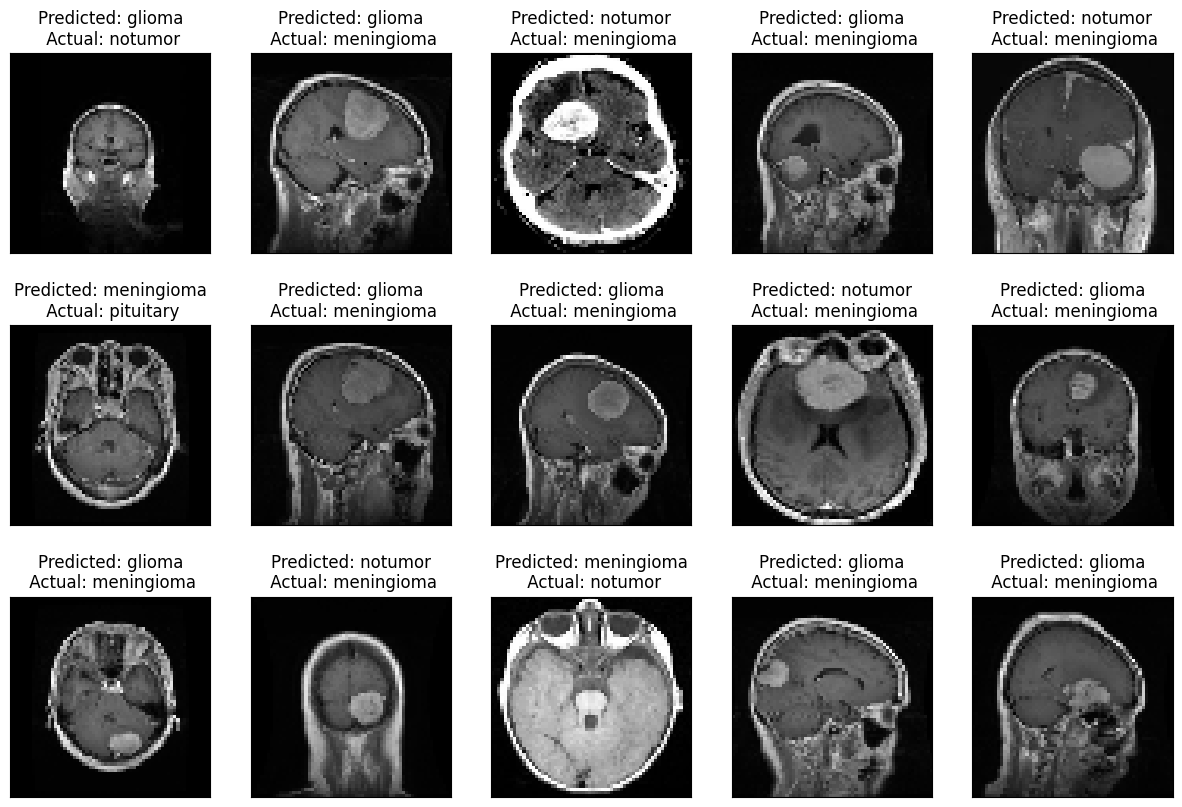

In [49]:
# Grab the incorrect images
incorrect_photos = y_test_encoded != y_pred_cnn

# Set up number of images and the configuration (row x col)
num_images = 15
columns = 5
rows = 3

# Set up subplot
fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 10))

# Flatten axes
ax = ax.flatten()

# Display incorrect images
for i, image in enumerate(X_test[incorrect_photos][:num_images]):
    ax[i].imshow(image, cmap='gray')

    # Get predicted label
    prediction = label_encoder.inverse_transform(y_pred_cnn[incorrect_photos])[i]

    # Get actual label
    actual = label_encoder.inverse_transform(y_test_encoded[incorrect_photos])[i]

    # Set the title of the subplot
    ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")

    # Hide the x and y ticks to make
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()
fig.tight_layout()

Once again, we see that many meningioma images are being misclassified. A common feature among these misclassified meningioma images is the presence of a large tumor that is visually noticeable, but the model is unable to interpret it correctly. More often than not, it classifies these images as glioma.

## Conclusion

In terms of overall model accuracy performance, our best model for image classification is the CNN, followed by SVM, Logistic Regression, and lastly, Random Forest.

| Model             | Train Accuracy | Test Accuracy |
|:-------------------:|:----------------:|:---------------:|
| Logistic Regression | 89.74%         | 81.46%        |
| Support Vector Machine (SVM) | 92.49%         | 88.33%        |
| Random Forest      | 83.96%         | 75.97%        |
| Convolutional Neural Network (CNN) | 95.95% | 90.69% |


Now lets compare the recall scores for each classifcation per model.

| Model                         | No Tumor Recall | Pituitary Recall | Glioma Recall | Meningioma Recall |
|:-------------------------------:|:-----------------:|:------------------:|:---------------:|:-------------------:|
| Logistic Regression            | 95%             | 95%              | 71%           | 61%               |
| Support Vector Machine (SVM)   | 97%             | 97%              | 82%           | 75%               |
| Random Forest                  | 93%             | 92%              | 63%           | 51%               |
| Convolutional Neural Network (CNN) | 99% | 95% | 93% | 68% |

All four models had difficulty classifying meningioma. Surprisingly, the SVM model achieved the best recall score for meningioma classification at 75%, even outperforming the CNN model. A possible hypothesis for this is that the models are unable to detect the larger tumor regions typically present in meningioma cases. This would require further analysis and the development of an even more robust model.

## Next Steps

The next step for Sprint 3 will be to focus purely on CNN models and begin further tuning it. We will add more layers, increase the number of epochs, and introduce dropout layers to prevent overfitting, evaluating how our model performs at each stage. The goal is to develop a robust tumor detection and classification model.